# ModCraft Lifecycle Stage Demonstration

This notebook demonstrates the new ModCraft v1.4.9 architecture with a focus on the clear separation of responsibilities between the Stage class, Heptapod plugin, and solver components. We'll use a lifecycle model example to illustrate two different approaches to solve dynamic models:

1. **In-situ Mode**: Where operators are attached directly to stage movers and the Stage manages the execution internally
2. **External Mode**: Where an external whisperer function manages the solution process 

We'll also explore how the architecture supports separating:
- Mathematical definitions (functions, constraints, domains)
- Symbolic references and representations
- Computational implementations

This allows for greater flexibility and modularity in model development.

## Setup and Imports

Let's start by importing the necessary modules and setting up our environment.



## The Architecture of ModCraft

Before we dive into the code, let's review the key architectural components of ModCraft:

1. **Stage Class**: A computational container that manages perches and movers in the CDC (Continuation, Decision, Arrival) paradigm. It provides:
   - Methods for solving economic dynamic programming models
   - Interfaces for initialization and numeric representation
   - Support for both in-situ and external solving modes

2. **Perches**: Store function dictionaries (both "up" and "down" functions) at specific points in the model circuit.
   - **Arrival (arvl)** perch: Agent's state at beginning of period (e.g., assets)
   - **Decision (dcsn)** perch: Agent's choice space (e.g., consumption decision)
   - **Continuation (cntn)** perch: Future value functions (e.g., expected utility)

3. **Movers**: Operators that transform functions between perches. Key movers include:
   - `cntn_to_dcsn`: Maps continuation values to decision space (backward direction)
   - `dcsn_to_arvl`: Maps decision values to arrival space (backward direction)
   - `arvl_to_dcsn`: Maps arrival to decision space (forward direction)
   - `dcsn_to_cntn`: Maps decision to continuation space (forward direction)

4. **Heptapod Plugin**: Provides model representation functionality, separating symbolic model definitions from computational implementations.

In [76]:
"""
Simplified import fix for ModCraft notebooks
"""
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pprint
import yaml

# Set up core paths
# Add the modcraft root directory to the Python path
# Adjust this if your notebook is not in the examples/StageWorkFlow directory
modcraft_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if modcraft_root not in sys.path:
    sys.path.append(modcraft_root)

notebook_dir = os.path.abspath(os.path.join(os.getcwd(), "examples","cons_indshock"))

# Check for src directory and add it if needed
src_dir = os.path.join(modcraft_root, "src")
if src_dir not in sys.path:
    sys.path.append(src_dir)

# Import required modules
from stagecraft import Stage
from heptapod import model_init, gen_num

# Print paths to verify setup
print(f"ModCraft root: {modcraft_root}")
print(f"Source directory: {src_dir}")
print(f"Current working directory: {os.getcwd()}")

# Import essential modules
from stagecraft import Stage
from heptapod import model_init as heptapod_model_init
from heptapod import gen_num as heptapod_gen_num
from DEGM.whisperer import (
    operator_factory_in_situ,
    whisperer_external,
    plot_results,
    build_lifecycle_t1_stage as initialize_lifecycle_t1_stage
)

# Set up other required variables
#image_dir = os.path.join(modcraft_root, 'images')
#if not os.path.exists(image_dir):
#    os.makedirs(image_dir)

config_file = os.path.join(notebook_dir, "ConsInd.yml")

# Print minimal confirmation
print(f"Imports successful. Working in: {modcraft_root}")

# Print minimal confirmation
print(f"Imports successful. Working in: {modcraft_root}") 

ModCraft root: /
Source directory: /src
Current working directory: /
Imports successful. Working in: /
Imports successful. Working in: /


## Setup: Create Image Directory

Let's create a directory for saving our output images.

## Configuration File

Let's examine the configuration file structure, which demonstrates the clean separation of mathematical representation from symbolic referencing and numeric implementation.

## Building a Lifecycle Stage

Let's define a helper function to build our lifecycle stage, which we'll use for both in-situ and external modes.

In [77]:
def build_lifecycle_t1_stage(config_file):
    """Build a Stage for the penultimate period (T-1) of a lifecycle model.

    Creates and initializes a lifecycle model stage with proper terminal
    value functions and initial arrays for continuation perch.

    Parameters
    ----------
    config_file : str
        Path to the configuration YAML file

    Returns
    -------
    Stage
        The initialized lifecycle stage with proper perch data
    """
    # Create Stage, providing initialization and numerical representation modules
    t1_stage = Stage(
        name="LifecycleT1Stage", 
        init_rep=heptapod_model_init, 
        num_rep=heptapod_gen_num
    )
    t1_stage.load_config(config_file)

    # Build computational model using num_rep (heptapod_gen_num)
    t1_stage.build_computational_model()
    
    # Initialize the stage using the function from the 1DEGM model
    initialize_lifecycle_t1_stage(config_file, t1_stage)

    return t1_stage

In [78]:
# Path to configuration file
config_file = os.path.join(notebook_dir, "ConsInd.yml")

# Display the configuration
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)
    print("Configuration structure:")
    # Print just the top-level keys to avoid overwhelming output
    print("Top-level config keys:", list(config.keys()))
    print("\nStage config keys:", list(config['stage'].keys()))
    print("\nMath section keys:", list(config['stage']['math'].keys()))

FileNotFoundError: [Errno 2] No such file or directory: '/examples/cons_indshock/ConsInd.yml'

## Approach 1: In-situ Mode

Let's demonstrate the in-situ mode, where operators are attached directly to stage movers and the Stage manages the execution internally.

In [ ]:
print("\n=== Building In-situ Mode Stage ===")

# Create the stage
t1_stage = build_lifecycle_t1_stage(config_file)

# Examine the stage status
print("\nStage status after initialization:")
print(f"Status flags: {t1_stage.status_flags}")

# Examine the perches in the stage
print("\nPerches in the stage:")
for name, perch in t1_stage.perches.items():
    print(f"- {name}: {perch}")

# Using operator_factory_in_situ from the 1DEGM model
t1_stage.operator_factory = operator_factory_in_situ
t1_stage.attach_operatorfactory_operators()

# Display stage status before solving
print(f"\nStage is portable: {t1_stage.status_flags['portable']}")
perches_with_initial_vals = [name for name, perch in t1_stage.perches.items() if perch.sol]
print(f"Perches with initial comp values: {perches_with_initial_vals}")


=== Building In-situ Mode Stage ===

Stage status after initialization:
Status flags: {'initialized': True, 'compiled': True, 'solvable': False, 'solved': False, 'simulated': False, 'portable': False, 'all_perches_initialized': True, 'all_perches_compiled': True, 'all_movers_initialized': True, 'all_movers_compiled': True}

Perches in the stage:
- arvl: Perch(arvl, has_model=True, initialized=[])
- dcsn: Perch(dcsn, has_model=True, initialized=[])
- cntn: Perch(cntn, has_model=True, initialized=[sol, up])
Mover dcsn set with comp <function operator_factory_dcsn_to_arvl.<locals>.T_dcsn_to_arvl at 0x7fa2783b6c10>
Mover cntn set with comp <function operator_factory_cntn_to_dcsn.<locals>.T_cntn_to_dcsn at 0x7fa2783b6ca0>
Stage is portable with all required backward movers.

Stage is portable: True
Perches with initial comp values: ['cntn']


Solving the model with in-situ mode...
Perches with initial comp values: ['cntn']
Performing backward solve in single pass...
Backward solve updated 2 perches: ['arvl', 'dcsn']
Backward solve completed successfully
In-situ mode: Solved backward
- Decision perch keys: ['policy', 'lambda_dcsn', 'vlu_dcsn']
- Arrival perch keys: ['vlu_arvl', 'lambda_arvl', 'cond_exp']
In-situ results plotted and saved to /Users/akshayshanker/Research/Repos/modcraft/examples/heptapod/images


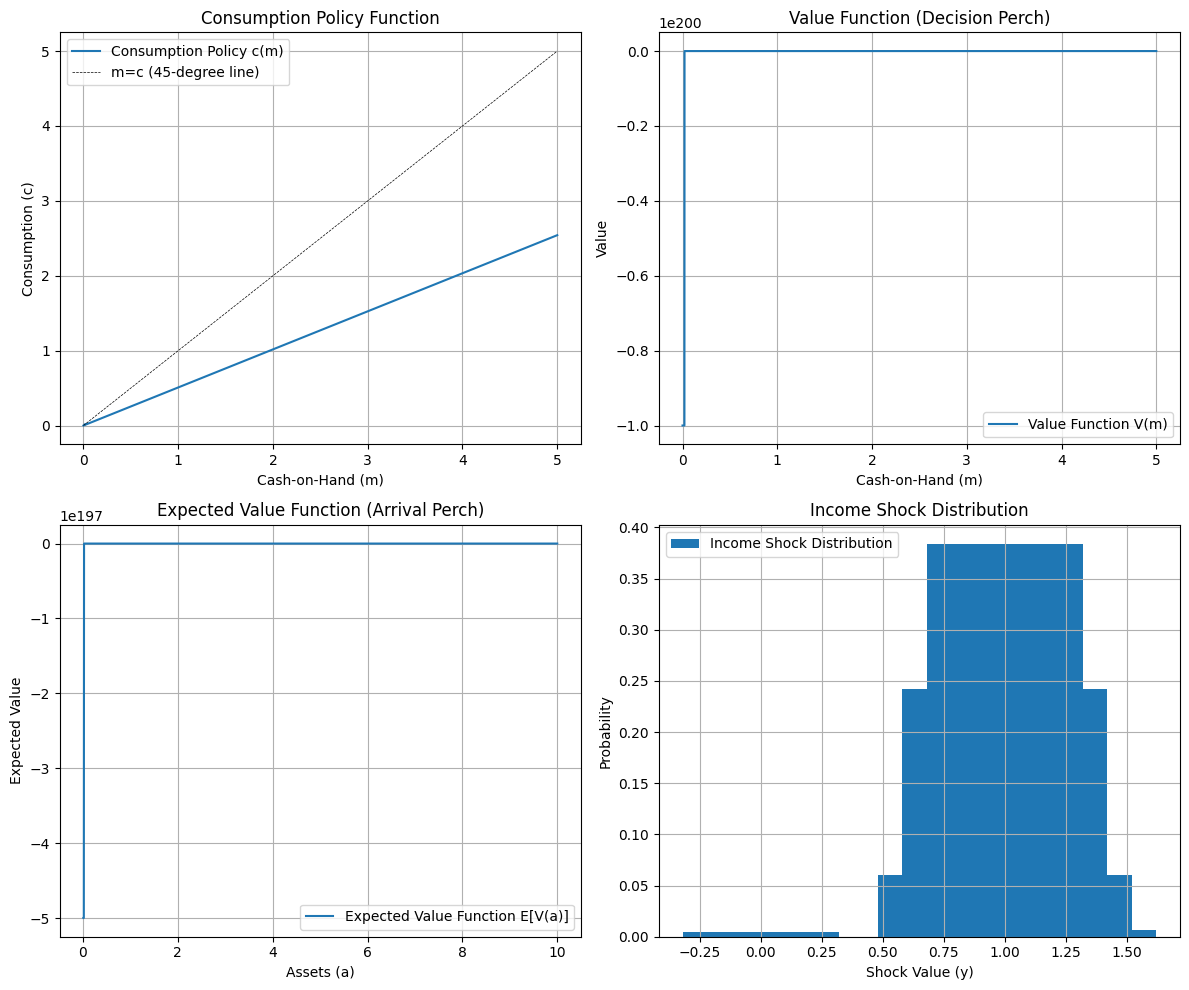

In [ ]:
# Solve the model using in-situ mode
print("Solving the model with in-situ mode...")
t1_stage.solve_backward()

# Get results
results_dcsn_insitu = t1_stage.perches["dcsn"].sol
results_arvl_insitu = t1_stage.perches["arvl"].sol

print("In-situ mode: Solved backward")
print(f"- Decision perch keys: {list(results_dcsn_insitu.keys())}")
print(f"- Arrival perch keys: {list(results_arvl_insitu.keys())}")

# Plot in-situ results
plot_results(t1_stage, results_dcsn_insitu, results_arvl_insitu, image_dir, filename_suffix="_insitu")
print(f"In-situ results plotted and saved to {image_dir}")

## Approach 2: External Mode

Now let's demonstrate the external mode, where an external whisperer function manages the solution process.


=== Building External Mode Stage ===
Solving the model with external mode...
Running external whisperer solver...
External whisperer solver completed successfully.
External mode: Solved using external whisperer
- Decision perch keys: ['policy', 'lambda_dcsn', 'vlu_dcsn']
- Arrival perch keys: ['vlu_arvl', 'lambda_arvl', 'cond_exp']
External results plotted and saved to /Users/akshayshanker/Research/Repos/modcraft/examples/heptapod/images


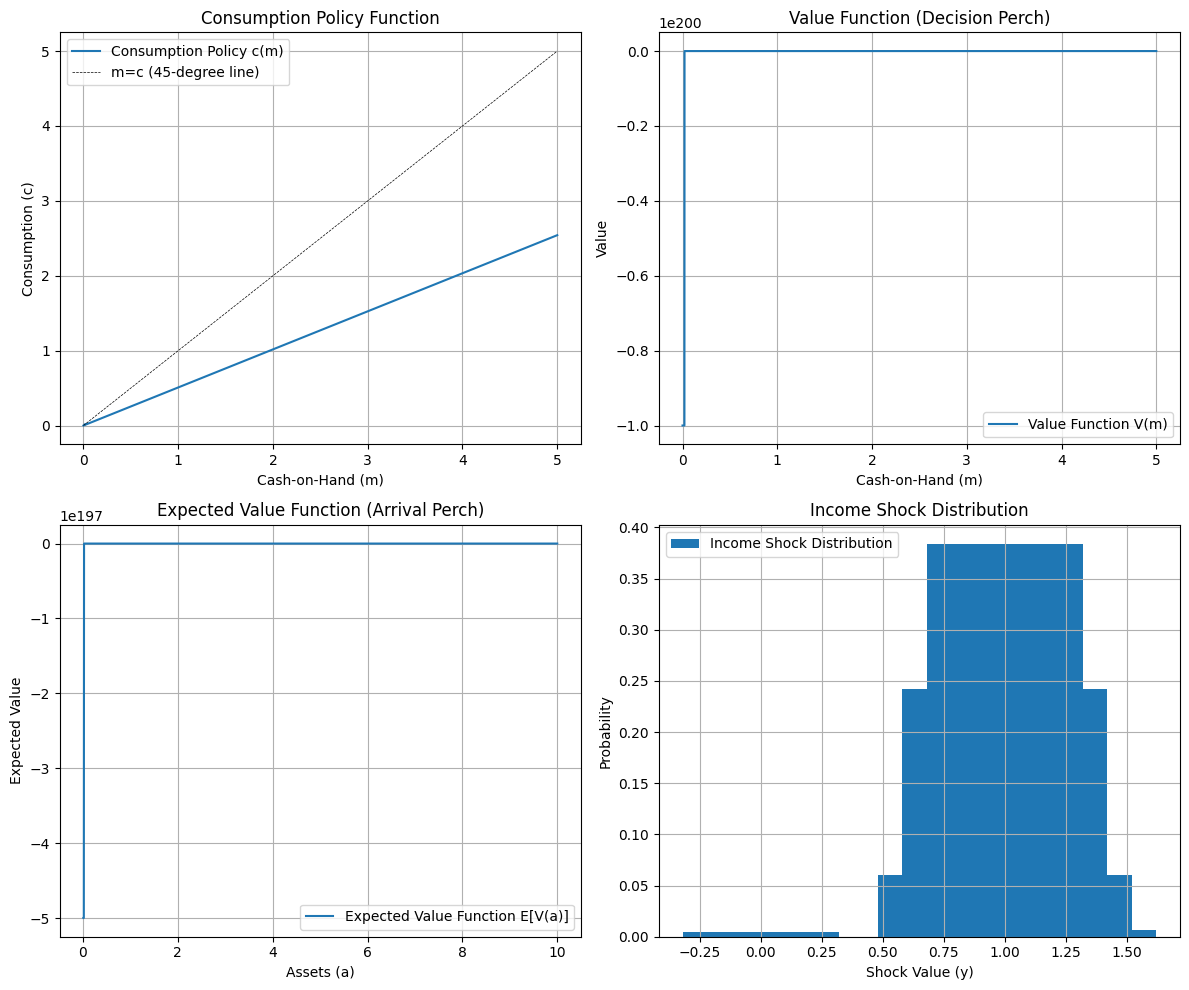

In [ ]:
print("\n=== Building External Mode Stage ===")

# Create a new stage for external solving
external_stage = build_lifecycle_t1_stage(config_file)

# Set mode to external
external_stage.model_mode = "external"

# Call the external whisperer from the 1DEGM model
print("Solving the model with external mode...")
whisperer_external(external_stage)

# Get results
results_dcsn_external = external_stage.perches["dcsn"].sol
results_arvl_external = external_stage.perches["arvl"].sol

print("External mode: Solved using external whisperer")
print(f"- Decision perch keys: {list(results_dcsn_external.keys())}")
print(f"- Arrival perch keys: {list(results_arvl_external.keys())}")

# Plot external results
plot_results(external_stage, results_dcsn_external, results_arvl_external, image_dir, filename_suffix="_external")
print(f"External results plotted and saved to {image_dir}")

## Comparing In-situ vs External Results

Let's compare the results from both approaches. They should be numerically equivalent if both implementations are correct.


=== Comparing In-situ vs External Results ===
Comparison plot saved to /Users/akshayshanker/Research/Repos/modcraft/examples/heptapod/images/heptapod_lifecycle_comparison.png
Maximum absolute difference in value functions: 0.000000e+00
Maximum absolute difference in policy functions: 0.000000e+00


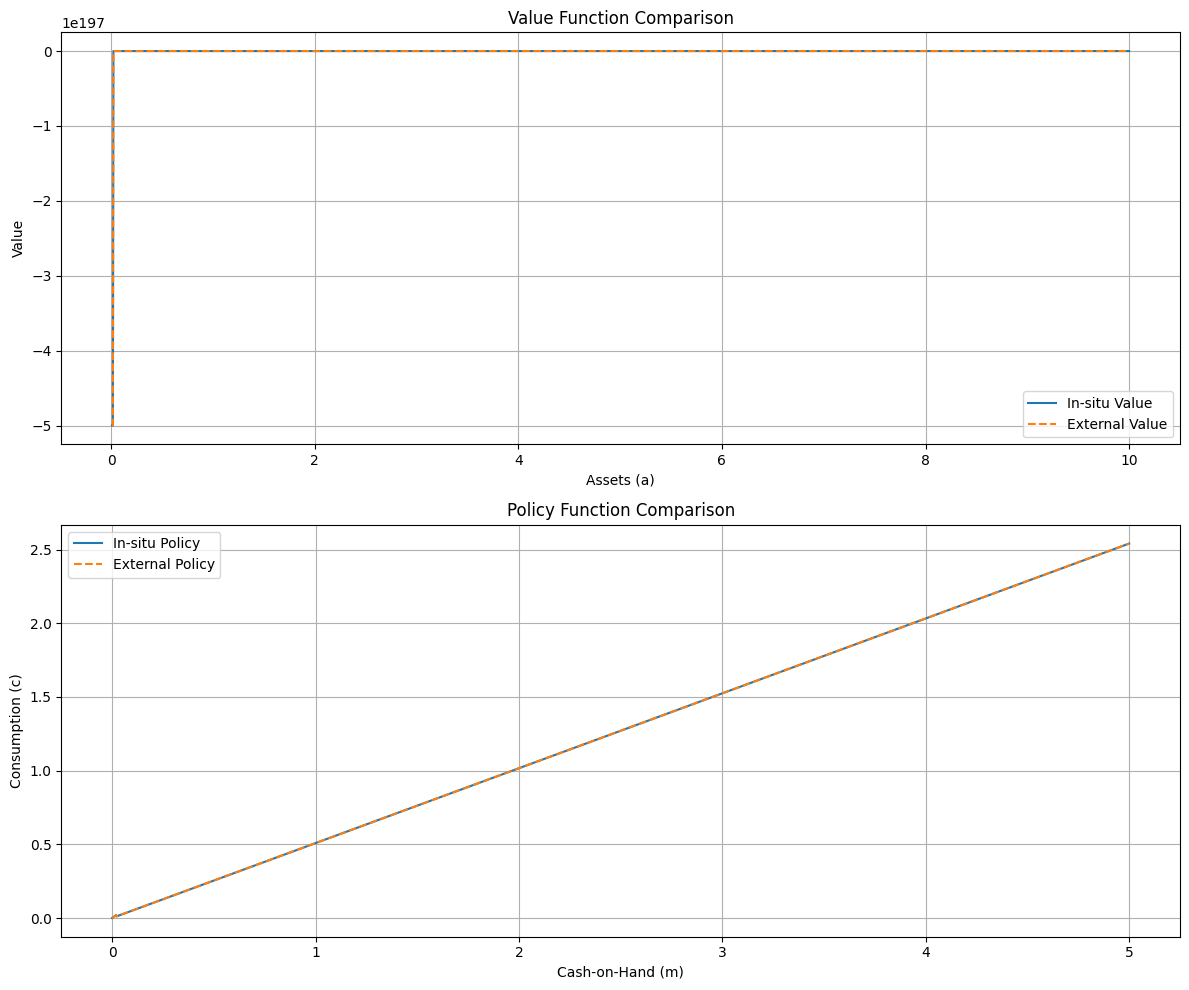

In [ ]:
# Compare results
print("\n=== Comparing In-situ vs External Results ===")
plt.figure(figsize=(12, 10))

# Value function comparison
plt.subplot(2, 1, 1)
a_grid = t1_stage.dcsn_to_arvl.model.num["arvl"]["a"]
plt.plot(a_grid, results_arvl_insitu["vlu_arvl"], label="In-situ Value")
plt.plot(a_grid, results_arvl_external["vlu_arvl"], linestyle='--', label="External Value")
plt.title("Value Function Comparison")
plt.xlabel("Assets (a)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# Policy function comparison
plt.subplot(2, 1, 2)
m_grid = t1_stage.dcsn_to_arvl.model.num["dcsn"]["m"]
plt.plot(m_grid, results_dcsn_insitu["policy"], label="In-situ Policy")
plt.plot(m_grid, results_dcsn_external["policy"], linestyle='--', label="External Policy")
plt.title("Policy Function Comparison")
plt.xlabel("Cash-on-Hand (m)")
plt.ylabel("Consumption (c)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(image_dir, "heptapod_lifecycle_comparison.png"))
print(f"Comparison plot saved to {os.path.join(image_dir, 'heptapod_lifecycle_comparison.png')}")

# Compute and print maximum absolute differences
value_diff = np.max(np.abs(results_arvl_insitu["vlu_arvl"] - results_arvl_external["vlu_arvl"]))
policy_diff = np.max(np.abs(results_dcsn_insitu["policy"] - results_dcsn_external["policy"]))
print(f"Maximum absolute difference in value functions: {value_diff:.6e}")
print(f"Maximum absolute difference in policy functions: {policy_diff:.6e}")

## Extending to Multiple Time Periods

Now let's demonstrate how to use these stages for multi-period lifecycle models through time iteration. We'll solve a lifecycle model backward from T-1 to T-10.

In [ ]:
# Function to run time iteration for multiple periods
def run_time_iteration(t1_stage, num_periods=10):
    """Run time iteration for multiple periods.

    Creates a sequence of lifecycle stages, where each stage's continuation values
    are initialized using the previous stage's arrival values.

    Parameters
    ----------
    t1_stage : Stage
        The initial (T-1) stage that has already been solved
    num_periods : int, optional
        Number of periods to iterate, by default 10

    Returns
    -------
    list
        List of solved stages from T-1 to T-num_periods
    """
    # Store all stages in a list, starting with the T-1 stage
    all_stages = [t1_stage]

    # Iterate backward through time
    for t in range(2, num_periods + 1):
        # Create a new stage with the same configuration
        config_file = os.path.join(notebook_dir, "ConsInd.yml")
        # Create a new stage providing both init and num reps upfront
        new_stage = Stage(
            name=f"LifecycleT{t}Stage",
            init_rep=heptapod_model_init,
            num_rep=heptapod_gen_num,
        )
        new_stage.load_config(config_file)

        # Build computational model using num_rep
        new_stage.build_computational_model()

        new_stage.operator_factory = operator_factory_in_situ
        new_stage.attach_operatorfactory_operators()

        # Attach the previous arrival data directly to the new stage's continuation perch
        new_stage.perches["cntn"].sol = {
            "vlu_cntn": all_stages[-1].perches["arvl"].sol["vlu_arvl"],
            "lambda_cntn": all_stages[-1].perches["arvl"].sol["lambda_arvl"],
        }

        new_stage.solve_backward()

        # Add the solved stage to our list
        all_stages.append(new_stage)

    return all_stages

# Run the time iteration and store all stages
print("Running time iteration for 10 periods...")
all_stages = run_time_iteration(t1_stage, num_periods=10)

# Print summary of solved stages
print("\nTime iteration complete. Solved stages:")
for i, stage in enumerate(all_stages):
    period = i + 1
    print(f"Stage T-{period}: Solved.")

Running time iteration for 10 periods...


FileNotFoundError: Configuration file not found: /Users/akshayshanker/Research/Repos/modcraft/examples/cons_indshock/example_config.yml


Multi-period results saved in: /Users/akshayshanker/Research/Repos/modcraft/examples/heptapod/images


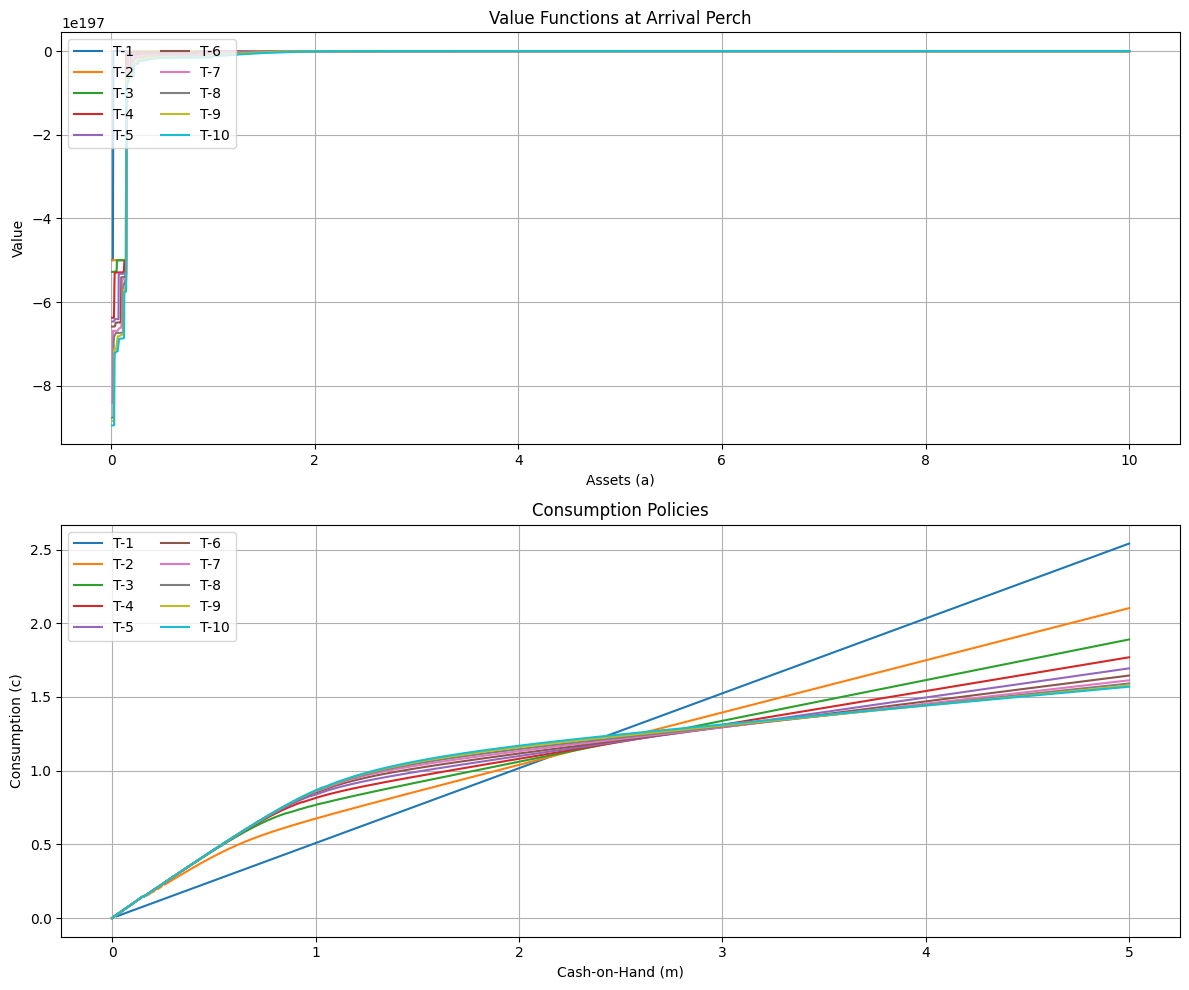

In [36]:
# Function to plot the results across multiple periods
def plot_multiperiod_results(all_stages, image_dir):
    """Plot value functions and policies across multiple periods.

    Parameters
    ----------
    all_stages : list
        List of solved stages
    image_dir : str
        Directory where to save the output images
    """
    plt.figure(figsize=(12, 10))

    # 1. Value functions at arrival perch
    plt.subplot(2, 1, 1)
    for i, stage in enumerate(all_stages):
        period = i + 1
        a_grid = stage.dcsn_to_arvl.model.num["arvl"]["a"]
        vlu_arvl = stage.perches["arvl"].sol["vlu_arvl"]
        plt.plot(a_grid, vlu_arvl, label=f"T-{period}")

    plt.title("Value Functions at Arrival Perch")
    plt.xlabel("Assets (a)")
    plt.ylabel("Value")
    plt.legend(loc="upper left", ncol=2)
    plt.grid(True)

    # 2. Consumption policies
    plt.subplot(2, 1, 2)
    for i, stage in enumerate(all_stages):
        period = i + 1
        m_grid = stage.dcsn_to_arvl.model.num["dcsn"]["m"]  # Get grid from mover
        policy = stage.perches["dcsn"].sol["policy"]
        plt.plot(m_grid, policy, label=f"T-{period}")

    plt.title("Consumption Policies")
    plt.xlabel("Cash-on-Hand (m)")
    plt.ylabel("Consumption (c)")
    plt.legend(loc="upper left", ncol=2)
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(image_dir, "heptapod_lifecycle_multiperiod_results.png"))

# Plot results across periods
plot_multiperiod_results(all_stages, image_dir)
print(f"\nMulti-period results saved in: {image_dir}")

## Conclusion

In this notebook, we've demonstrated two different approaches to solving lifecycle models using the ModCraft framework:

1. **In-situ Mode**: Operators are attached directly to stage movers, and the Stage manages the execution internally through the `solve_backward()` method.
2. **External Mode**: An external whisperer function manages the solution process, giving more control over the execution flow.

Both approaches produce identical results, showing the flexibility of the ModCraft architecture.

We've also demonstrated how to use these approaches in a multi-period setting with time iteration, allowing for the solution of complex dynamic programming problems.

Key architectural features illustrated in this example:

- **Clear separation of concerns**: Mathematical model definitions, symbolic references, and computational implementations are cleanly separated
- **Modularity**: Different solvers (in-situ vs external) can be used with the same model representation
- **Flexibility**: The same approach can be extended to multi-period problems through time iteration

This design makes ModCraft a powerful tool for economic modeling, allowing researchers to focus on their model's economic logic rather than computational details. 